# Libs

In [63]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import time
import datetime
import pickle
import os

# Uploading

In [4]:
# 1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. 
# Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
features_init = pd.read_csv('./final_hw/features.csv', index_col='match_id')
features_init.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [5]:
# - Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
#     - `duration`: длительность
#     - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
#     - Состояние башен и барраков к концу матча (см. описание полей набора данных)
#         - `tower_status_radiant`
#         - `tower_status_dire`
#         - `barracks_status_radiant`
#         - `barracks_status_dire`
drop_columns = ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire']
features_v1 = features_init.drop(drop_columns, axis=1)
features_v1

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1450265551,1,47,4,1706,1198,17,0,1,8,...,0,-29.0,180.0,-76.0,180.0,3,4,3,0,-24.0
114403,1450277704,0,43,4,1793,1416,17,0,1,5,...,0,-5.0,NaN,-82.0,NaN,4,3,2,0,-17.0
114404,1450291848,1,98,4,1399,540,1,0,0,5,...,2,-32.0,249.0,-70.0,NaN,1,1,3,1,-15.0


In [6]:
# 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? 
# Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
miss_val = features_v1.count().reset_index().rename(columns={0: 'count'}).query('count < 97230')
miss_val

,index,count
82,first_blood_time,77677
83,first_blood_team,77677
84,first_blood_player1,77677
85,first_blood_player2,53243
86,radiant_bottle_time,81539
87,radiant_courier_time,96538
88,radiant_flying_courier_time,69751
93,radiant_first_ward_time,95394
94,dire_bottle_time,81087
95,dire_courier_time,96554


In [7]:
# 3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической 
# регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим 
# вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения 
# вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. 
# Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, 
# но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
features_offset = features_v1.fillna(-9999)
features_zero = features_v1.fillna(0)
for col in miss_val['index']:
    print(f'Column: {col}', features_v1[col].mean())
    features_avg = features_v1.fillna(features_v1[features_v1[col].notna()].mean())

Column: first_blood_time 97.6880286313838
Column: first_blood_team 0.5218146941823191
Column: first_blood_player1 4.5934832704661614
Column: first_blood_player2 4.383224085795316
Column: radiant_bottle_time 126.80025509265505
Column: radiant_courier_time -80.05951024467049
Column: radiant_flying_courier_time 215.98712563260742
Column: radiant_first_ward_time -6.875746902320901
Column: dire_bottle_time 127.21502830293389
Column: dire_courier_time -80.19189261967396
Column: dire_flying_courier_time 214.8705364674127
Column: dire_first_ward_time -6.901922351264098


In [8]:
# 4. Какой столбец содержит целевую переменную? Запишите его название.
target = features_init['radiant_win']
target

match_id
0         1
1         1
2         0
3         0
4         0
         ..
114402    0
114403    1
114404    0
114405    0
114406    1
Name: radiant_win, Length: 97230, dtype: int64

In [7]:
# 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на 
# имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), 
# не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, 
# и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга 
# (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум 
# протестируйте следующие значения для количества деревьев: 10, 20, 30).  
# Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, 
# скорее всего, продолжит расти при дальнейшем его увеличении?

# GradientBoostingClassifier

In [9]:
# np.array(features_v3.columns)
for col in features_offset.columns:
    if features_offset[col].dtype not in ['int64']:
        print(col, features_offset[col].dtype)

first_blood_time float64
first_blood_team float64
first_blood_player1 float64
first_blood_player2 float64
radiant_bottle_time float64
radiant_courier_time float64
radiant_flying_courier_time float64
radiant_first_ward_time float64
dire_bottle_time float64
dire_courier_time float64
dire_flying_courier_time float64
dire_first_ward_time float64


In [10]:
target.value_counts(normalize=True)

radiant_win
1    0.518503
0    0.481497
Name: proportion, dtype: float64

## Offset X

In [41]:
start_time = datetime.datetime.now()

X = features_offset.values
y = target.values
n_estim = 30
clf = GradientBoostingClassifier(n_estimators=n_estim)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')

print('features_avg\n','n_estimators:', n_estim, 'mean roc_auc:', scores.mean().round(4))
print('Time elapsed:', datetime.datetime.now() - start_time)

features_avg 
 n_estimators: 30 mean roc_auc: 0.6897
Time elapsed: 0:05:41.377858


## Zero X

In [16]:
start_time = datetime.datetime.now()

X = features_offset.values
y = target.values
n_estim = 30
clf = GradientBoostingClassifier(n_estimators=n_estim)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')

print('features_avg\n','n_estimators:', n_estim, 'mean roc_auc:', scores.mean().round(4))
print('Time elapsed:', datetime.datetime.now() - start_time)

features_avg
 n_estimators: 30 mean roc_auc: 0.6897
Time elapsed: 0:02:29.727208


## Mean X

In [17]:
start_time = datetime.datetime.now()

X = features_avg.values
y = target.values
n_estim = 30
clf = GradientBoostingClassifier(n_estimators=n_estim)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')

print('features_avg \n','n_estimators:', n_estim, 'mean roc_auc:', scores.mean().round(4))
print('Time elapsed:', datetime.datetime.now() - start_time)

features_avg 
 n_estimators: 30 mean roc_auc: 0.6891
Time elapsed: 0:02:18.692455


## Experiments with max_depth

In [ ]:
# X = features_avg.values
# y = target.values

# df_lst = []
# for n_estim in [10, 20, 30, 50, 70, 100]:
#     clf = GradientBoostingClassifier(n_estimators=n_estim)
#     kf = KFold(n_splits=5, shuffle=True, random_state=1)
#     scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')
#     df = pd.DataFrame({'n_estimatoes':n_estim, 'roc_auc':scores.mean()}, index=[0])
#     df_lst.append(df)
# df = pd.concat(df_lst).reset_index(drop=True)

Text(0.5, 1.0, 'ROC-AUC vs n_estimators for features_avg')

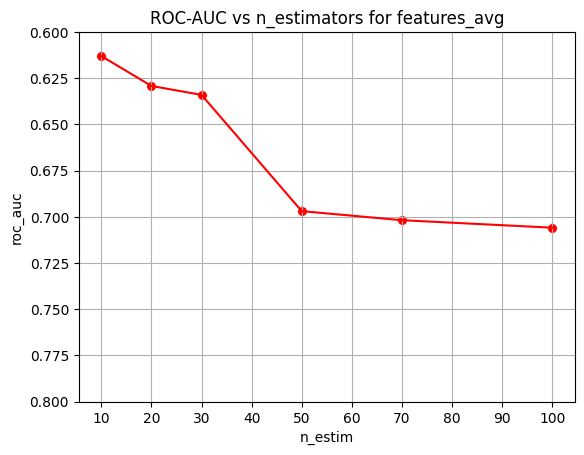

In [19]:
n_estim = [10, 20, 30, 50, 70, 100]
roc_auc = [0.613021, 0.629199, 0.634033, 0.696953, 0.701850, 0.705901]
df_elbow = pd.DataFrame({'n_estim':n_estim, 'roc_auc':roc_auc})
sns.lineplot(x='n_estim', y='roc_auc', data=df_elbow, c='red')
sns.scatterplot(x='n_estim', y='roc_auc', data=df_elbow, s=50, c='red')
plt.ylim(0.8, 0.6)
plt.xticks(ticks=range(10, 110, 10))
plt.grid()
plt.title('ROC-AUC vs n_estimators for features_avg')

## Final run GB

In [27]:
start_time = datetime.datetime.now()
typeX_dict = {'features_avg':features_avg, 
              'features_offset':features_offset, 
              'features_zero':features_zero}

X = typeX_dict['features_avg'].values
y = target.values
n_estim = 100
folder = r'C:\jupyter\coursera_ml_intoduction\week7'
name = 'model_grad_boost.pkl'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(n_estimators=n_estim)
model.fit(X_train, y_train)

with open(os.path.join(folder, name), 'wb') as file:
    pickle.dump(model, file)

with open(os.path.join(folder, name), 'rb') as file:
    loaded_model = pickle.load(file)

y_pred = loaded_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'model: {name} n_estimators: {n_estim} roc_auc: {roc_auc.mean().round(4)}')
print('Time elapsed:', datetime.datetime.now() - start_time)

model: model_grad_boost.pkl n_estimators: 100 roc_auc: 0.6428
Time elapsed: 0:01:29.049698


## Отчет

1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках 
(ответьте на этот вопрос для двух любых признаков)?
Признаки ниже имеют пропуски среди своих значений:
- first_blood_time
- first_blood_team
- first_blood_player1
- first_blood_player2

   Это связано с тем, что указаные события могли не успеть произойти за первые 5 минут матча.

2. Как называется столбец, содержащий целевую переменную?

   Столбец называется *['radiant_win']*

3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.

   Кросс-валидация при 30 деревьях закончилась за **05:37 мин**

4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

   **Да, смысл есть.** Заметное снижение прироста roc_auc начинается после глубины в 50 деревьев. См. график выше. 

   **Ускорить обучение** можно за счет:
   - n_estimators=30,          # снижение количества деревьев
   - learning_rate=0.1,        # увеличение learning_rate
   - max_depth=3,              # уменьшенение максимальной глубины дерева
   - subsample=0.8,            # использование подмножества
   - n_iter_no_change=10,      # ранняя остановка если нет прироста качества
   - validation_fraction=0.1,  # изменение доли данных трейнинга для валидации


# LogisticRegression

## Q1

In [149]:
# 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) 
# с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. 
# Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? 
# Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? 
# Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

typeX_dict = {'features_avg':features_avg, 
              'features_offset':features_offset, 
              'features_zero':features_zero}

df_lst = []
for item in typeX_dict:
    X = typeX_dict[item].values
    y = target.values
    scaler = StandardScaler()
    X = scaler.fit_transform(X) 
    for C in [0.001, 0.01, 0.1, 1, 10]:
        clf = LogisticRegression(penalty='l2', C=C, max_iter=10000)
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')
        print(item, C, cv_scores.mean().round(4))
        df = pd.DataFrame({'typeX':item, 'C':C, 'roc_auc':cv_scores.mean()}, index=[0])
        df_lst.append(df)
q1_result = pd.concat(df_lst).reset_index(drop=True)
q1_result['task'] = 'q1'
q1_result['int_num'] = [int(i) for i in range(len(q1_result))]

features_avg 0.001 0.7166
features_avg 0.01 0.7167
features_avg 0.1 0.7167
features_avg 1 0.7167
features_avg 10 0.7167
features_offset 0.001 0.7154
features_offset 0.01 0.7156
features_offset 0.1 0.7155
features_offset 1 0.7155
features_offset 10 0.7155
features_zero 0.001 0.7162
features_zero 0.01 0.7164
features_zero 0.1 0.7163
features_zero 1 0.7163
features_zero 10 0.7163


## Q2

In [150]:
# 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. 
# Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. 
# Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. 
# Изменилось ли качество? Чем вы можете это объяснить?

typeX_dict = {'features_avg':features_avg, 
              'features_offset':features_offset, 
              'features_zero':features_zero}

df_lst = []
for item in typeX_dict:
    col_lst = []
    for col in list(typeX_dict[item].columns):
        for i in range(1, 6):
            if f'r{i}_' in col:
                col_lst.append(col)
            if f'd{i}_' in col:
                col_lst.append(col)
    col_lst.append('lobby_type')
    features_drop = typeX_dict[item].drop(col_lst, axis=1)

    X = features_drop.values
    y = target.values
    for C in [0.001, 0.01, 0.1, 1, 10]:
        clf = LogisticRegression(C=C, max_iter=10000)
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')
        print(item, C, cv_scores.mean().round(4))
        df = pd.DataFrame({'typeX':item, 'C':C, 'roc_auc':cv_scores.mean()}, index=[0])
        df_lst.append(df)
q2_result = pd.concat(df_lst).reset_index(drop=True)
q2_result['task'] = 'q2'
q2_result['int_num'] = [int(i) for i in range(len(q2_result))]

features_avg 0.001 0.5135
features_avg 0.01 0.5135
features_avg 0.1 0.5135
features_avg 1 0.5135
features_avg 10 0.5135
features_offset 0.001 0.5508
features_offset 0.01 0.5508
features_offset 0.1 0.5508
features_offset 1 0.5508
features_offset 10 0.5508
features_zero 0.001 0.5135
features_zero 0.01 0.5135
features_zero 0.1 0.5135
features_zero 1 0.5135
features_zero 10 0.5135


## Q3

'Количество героев: 108'

Распределение побед героев по командам на графике ниже


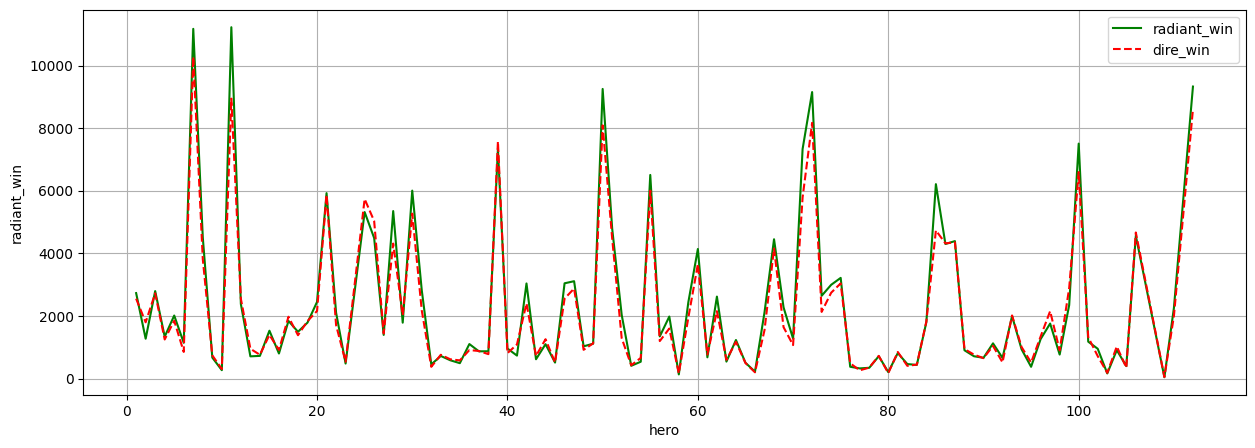

In [143]:
# 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. 
# Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных 
# идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

typeX_dict = {'features_avg':features_avg, 
              'features_offset':features_offset, 
              'features_zero':features_zero}

def heroes_counting():
    hero_lst = []
    for col in list(typeX_dict['features_avg'].columns):
        for i in range(1, 6):
            if f'r{i}_hero' in col:
                hero_lst.append(col)
            if f'd{i}_hero' in col:
                hero_lst.append(col)
    hero_lst_v2 = hero_lst
    features_avg_hero = features_avg[hero_lst_v2]
    features_avg_hero_v2 = pd.concat([features_avg_hero, features_init['radiant_win']], axis=1)
    features_avg_hero_v2['dire_win'] = 0
    features_avg_hero_v2.loc[features_avg_hero_v2['radiant_win'] == 0, 'dire_win'] = 1

    hero_col_lst = []
    for j in range(1, 6):
        df = features_avg_hero_v2.groupby(f'r{j}_hero').agg({'radiant_win':'sum', 'dire_win':'sum'}).reset_index().sort_values('radiant_win', ascending=False)
        df = df.rename(columns={f'r{j}_hero':'hero'})
        df['num'] = j
        hero_col_lst.append(df)

    hero_df = pd.concat(hero_col_lst)
    hero_df_final = hero_df.groupby('hero').agg({'radiant_win':'sum', 'dire_win':'sum'}).reset_index().sort_values('radiant_win', ascending=False)
    return hero_df_final

hero_df_final = heroes_counting()

display(f'Количество героев: {len(hero_df_final.hero.unique())}')
print('Распределение побед героев по командам на графике ниже')

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='hero', y='radiant_win', data=hero_df_final, label='radiant_win', c='green')
sns.lineplot(x='hero', y='dire_win', data=hero_df_final, label='dire_win', c='red', ls='--')
plt.grid()

## Q4

In [151]:
# 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. 
# Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; 
# минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. 
# Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.
# N — количество различных героев в выборке
# 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. 
# Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

typeX_dict = {'features_avg':features_avg, 
              'features_offset':features_offset, 
              'features_zero':features_zero}

def heroes_counting():
    hero_lst = []
    for col in list(typeX_dict['features_avg'].columns):
        for i in range(1, 6):
            if f'r{i}_hero' in col:
                hero_lst.append(col)
            if f'd{i}_hero' in col:
                hero_lst.append(col)
    hero_lst_v2 = hero_lst
    features_avg_hero = features_avg[hero_lst_v2]
    features_avg_hero_v2 = pd.concat([features_avg_hero, features_init['radiant_win']], axis=1)
    features_avg_hero_v2['dire_win'] = 0
    features_avg_hero_v2.loc[features_avg_hero_v2['radiant_win'] == 0, 'dire_win'] = 1

    hero_col_lst = []
    for j in range(1, 6):
        df = features_avg_hero_v2.groupby(f'r{j}_hero').agg({'radiant_win':'sum', 'dire_win':'sum'}).reset_index().sort_values('radiant_win', ascending=False)
        df = df.rename(columns={f'r{j}_hero':'hero'})
        df['num'] = j
        hero_col_lst.append(df)

    hero_df = pd.concat(hero_col_lst)
    hero_df_final = hero_df.groupby('hero').agg({'radiant_win':'sum', 'dire_win':'sum'}).reset_index().sort_values('radiant_win', ascending=False)
    return hero_df_final
hero_df_final = heroes_counting()
N = hero_df_final['hero'].nunique()

def ohe_heroes():
    data = typeX_dict['features_avg']
    X_pick = np.zeros((data.shape[0], N))
    X_pick_df = pd.DataFrame(X_pick, columns=['h_'+str(i) for i in hero_df_final['hero'].sort_values().values])

    for i, match_id in enumerate(data.index):
        for p in range(5):
            r_num = 'h_' + str(data.loc[match_id, f'r{p+1}_hero'])
            X_pick_df.loc[i, r_num] = 1
            d_num = 'h_' + str(data.loc[match_id, f'd{p+1}_hero'])
            X_pick_df.loc[i, d_num] = -1
    return X_pick_df
X_pick_df = ohe_heroes()

df_lst = []
for item in typeX_dict:
    col_lst = []
    for col in list(typeX_dict[item].columns):
        for i in range(1, 6):
            if f'r{i}_' in col:
                col_lst.append(col)
            if f'd{i}_' in col:
                col_lst.append(col)
    col_lst.append('lobby_type')
    features_drop = typeX_dict[item].drop(col_lst, axis=1)

    data_heros_ohe = features_drop.reset_index().join(X_pick_df)

    X = data_heros_ohe.drop('match_id', axis=1).values
    y = target.values

    scaler = StandardScaler()
    X = scaler.fit_transform(X) 
    for C in [0.001, 0.01, 0.1, 1, 10]:
        clf = LogisticRegression(penalty='l2', C=C, max_iter=10000)
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')
        print(item, C, cv_scores.mean().round(4))
        df = pd.DataFrame({'typeX':item, 'C':C, 'roc_auc':cv_scores.mean()}, index=[0])
        df_lst.append(df)
q4_result = pd.concat(df_lst).reset_index(drop=True)
q4_result['task'] = 'q4'
q4_result['int_num'] = [int(i) for i in range(len(q4_result))]

features_avg 0.001 0.6669
features_avg 0.01 0.667
features_avg 0.1 0.667
features_avg 1 0.667
features_avg 10 0.667
features_offset 0.001 0.6635
features_offset 0.01 0.6636
features_offset 0.1 0.6636
features_offset 1 0.6636
features_offset 10 0.6636
features_zero 0.001 0.6668
features_zero 0.01 0.6668
features_zero 0.1 0.6668
features_zero 1 0.6668
features_zero 10 0.6668


## Q5

,typeX,C,roc_auc,task,int_num
1,features_avg,0.01,0.716744,q1,1


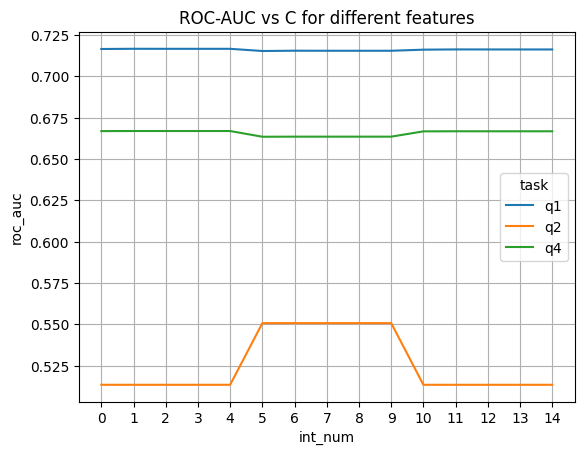

In [164]:
# 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей 
# (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], 
# не совпадают между собой (т.е. что модель не получилась константной).
final_q_result = pd.concat([q1_result, q2_result, q4_result]).reset_index(drop=True)
final_q_result
sns.lineplot(x='int_num', y='roc_auc', data=final_q_result, hue='task')
plt.xticks(ticks=range(0, 15, 1))
plt.title('ROC-AUC vs C for different features')
plt.grid();
final_q_result.sort_values('roc_auc', ascending=False).iloc[:1]

## Final run LR

In [31]:
start_time = datetime.datetime.now()
typeX_dict = {'features_avg':features_avg, 
              'features_offset':features_offset, 
              'features_zero':features_zero}

X = typeX_dict['features_avg'].values
y = target.values
C = 0.01
folder = r'C:\jupyter\coursera_ml_intoduction\week7'
name = 'model_log_reg.pkl'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(penalty='l2', C=C, max_iter=10000)
model.fit(X_train, y_train)

with open(os.path.join(folder, name), 'wb') as file:
    pickle.dump(model, file)

with open(os.path.join(folder, name), 'rb') as file:
    loaded_model = pickle.load(file)

y_pred = loaded_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'model: {name} C_value: {C} roc_auc: {roc_auc.mean().round(4)}')
print('Time elapsed:', datetime.datetime.now() - start_time)

model: model_log_reg.pkl C_value: 0.01 roc_auc: 0.6423
Time elapsed: 0:00:01.232488


In [ ]:
# grad_boost
# 1. model: model_grad_boost.pkl n_estimators: 100 roc_auc: 0.6428
# 2. Time elapsed: 0:01:29

# log_reg
# 1. model: model_log_reg.pkl C_value: 0.01 roc_auc: 0.6423
# 2. Time elapsed: 0:00:01

## Test csv

In [47]:
feature_test = pd.read_csv(r'C:\jupyter\coursera_ml_intoduction\week7\final_hw\features_test.csv', index_col='match_id')

rows = feature_test.shape[0]
miss_val_test = feature_test.count().reset_index().rename(columns={0: 'count'}).query(f'count < {rows}')
for col in miss_val_test['index']:
    print(f'Column: {col}', features_v1[col].mean())
    feature_test_avg = features_v1.fillna(features_v1[features_v1[col].notna()].mean())

Column: first_blood_time 97.6880286313838
Column: first_blood_team 0.5218146941823191
Column: first_blood_player1 4.5934832704661614
Column: first_blood_player2 4.383224085795316
Column: radiant_bottle_time 126.80025509265505
Column: radiant_courier_time -80.05951024467049
Column: radiant_flying_courier_time 215.98712563260742
Column: radiant_first_ward_time -6.875746902320901
Column: dire_bottle_time 127.21502830293389
Column: dire_courier_time -80.19189261967396
Column: dire_flying_courier_time 214.8705364674127
Column: dire_first_ward_time -6.901922351264098


In [64]:
def model_prediction(name, X_test):
    folder = r'C:\jupyter\coursera_ml_intoduction\week7'
    with open(os.path.join(folder, name), 'rb') as file:
        loaded_model = pickle.load(file)
    y_pred = loaded_model.predict(X_test)
    pred = loaded_model.predict_proba(X_test)[:, 1]
    return y_pred, pred
match_id = feature_test_avg.index
y_pred_logreg, pred_logreg = model_prediction('model_log_reg.pkl', feature_test_avg)
y_pred_gradboost, pred_gradboost = model_prediction('model_grad_boost.pkl', feature_test_avg)

In [71]:
y_pred_logreg_df = pd.DataFrame({'match_id':match_id, 'radiant_win_int':y_pred_logreg, 'radiant_win':pred_logreg})
# y_pred_logreg_df.drop('radiant_win_int', axis=1).to_csv(r'C:\jupyter\coursera_ml_intoduction\week7\final_hw\y_pred_logreg.csv', index=False)

y_pred_gradboost_df = pd.DataFrame({'match_id':match_id, 'radiant_win_int':y_pred_gradboost, 'radiant_win':pred_gradboost})
# y_pred_gradboost_df.drop('radiant_win_int', axis=1).to_csv(r'C:\jupyter\coursera_ml_intoduction\week7\final_hw\y_pred_gradboost.csv', index=False)

logreg_prob_max = y_pred_logreg_df.sort_values('radiant_win', ascending=False).iloc[0]['radiant_win']
logreg_prob_min = y_pred_logreg_df.sort_values('radiant_win', ascending=True).iloc[0]['radiant_win']
gradboost_prob_max = y_pred_gradboost_df.sort_values('radiant_win', ascending=False).iloc[0]['radiant_win']
gradboost_prob_min = y_pred_gradboost_df.sort_values('radiant_win', ascending=True).iloc[0]['radiant_win']
maxmin_df = pd.DataFrame({'model':['logreg', 'gradboost'], 'max':[logreg_prob_max, gradboost_prob_max], 'min':[logreg_prob_min, gradboost_prob_min]})
maxmin_df

,model,max,min
0,logreg,0.997252,0.002054
1,gradboost,0.940904,0.075248


## Отчет

1. Какое качество получилось у логистической регрессии над всеми исходными признаками? 
Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Если сравнивать лучшую модель градиентного бустинга и логистической регрессии, то результат roc_auc на сплитованных тестовых данных отличается только в 4м знаке после запятой, 0.6428 против 0.6423 соответственно. Видимо, если линейные и ансамблевые методы дают примерно одинаковый результат, значит это предел качества при текущих входных данных. Дальшее улучшение возможно после оптимизации входных параметров и улучшенного фича-инжиниринга.<br>
Логистическая регрессия в данном случае работает в 89 раз быстрее, чем градиентный бустинг: 1 сек против 1 мин 29 сек соответственно. 

2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? 
Чем вы можете объяснить это изменение?

Удаление категориальных признаков lobby_type, rN_hero, dN_hero крайне отрицательно сказалось на качестве регрессии, roc_auc при кросс-валидации упал на 17,5%, с примрено 0.725 до 0.55 по roc_auc. Видимо данные признаки крайне важны для успешного предсказания победы одной из команд.

3. Сколько различных идентификаторов героев существует в данной игре?

Я насчитал 108 различных идентификаторов.

4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

При использовании матрицы признаков вместо просто номеров героев ухудшилок качество логистический регресии на кросс-валидации на 5%. Мне сложно объяснить данный факт, потому что линейные методы должны хорошо справляться с разреженными матрицами и "мешком слов".

5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

Я так и не понял какой из алгоритмов считать "лучшим", поэтому значений мин-макс прогнозов для обоих алгоритмов.

| Model      | Max       | Min       |
|------------|-----------|-----------|
| log_reg     | 0.997252  | 0.002054  |
| grad_boost  | 0.940904  | 0.075248  |